In [1]:
print('Hello world!')

Hello world!


### Experimental Setting

In [2]:
REVERSE_INPUT = False
REVERSE_OUTPUT = True
OPERATOR = '+'
NUM1_RANGE = (10,99)
NUM2_RANGE = (10,99)
TRAINING_SAMPLE_SIZE = 1000
TEST_SAMPLE_SIZE = 10
TRAINING_EPOCH = 100

### Transformer for Calculation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [4]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed_all(12345)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Dataset Class
class AdditionDataset(Dataset):
    def __init__(self, num_samples):
        self.samples = [self.generate_sample() for _ in range(num_samples)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    @staticmethod
    def generate_sample(operator=OPERATOR, reverse_in=REVERSE_INPUT, reverse_out=REVERSE_OUTPUT):
        num1 = random.randint(NUM1_RANGE[0], NUM1_RANGE[1])
        num2 = random.randint(NUM2_RANGE[0], NUM2_RANGE[1])
        result = eval(f'{num1}{operator}{num2}')

        if reverse_in:
            num1 = str(num1)[::-1]
            num2 = str(num2)[::-1]
        else:
            num1 = str(num1)
            num2 = str(num2)

        if reverse_out:
            result = str(result)[::-1]
        else:
            result = str(result)

        return num1+operator+num2+'='+result

In [7]:
# Hyperparameter
MAX_LEN = 16
EMBED_SIZE = 384 #256
NUM_HEADS = 6 #8
NUM_LAYERS = 3 #6 #3
DROPOUT = 0 #0.1
LEARNING_RATE = 1e-6 #1e-3
EPOCHS = TRAINING_EPOCH

In [8]:
# Tokenization
ONEHOT_IDX = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, OPERATOR: 10, '=': 11}
TOKENS = ''.join(ONEHOT_IDX.keys())
VOCAB_SIZE = len(TOKENS)

def char_to_idx(char):
    return ONEHOT_IDX[char]

def idx_to_char(idx):
    return TOKENS[idx]

In [9]:
# Model definition
class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len, num_heads, num_layers, dropout=0.1):
        super(TransformerDecoderModel, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_size)
        self.pos_enc = nn.Embedding(max_len, embed_size)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, 
            nhead=num_heads, 
            bias=False,
            activation='gelu',
            batch_first=True,)
        
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.pos = torch.arange(0, max_len, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

    def forward(self, src):
        batch_size, seq_len = src.shape
        tok_emb = self.token_emb(src)  # (batch=1, seq_len, emb_dim)
        pos_emb = self.pos_enc(self.pos)[:,:seq_len,:]
        x = self.dropout(tok_emb + pos_emb)
        memory = torch.zeros_like(x)  # No encoder output
        output = self.transformer_decoder(x, memory)
        return self.fc_out(output)

In [10]:
# Visualization
def vis_pca(data, labels, title='', show=False):
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=8)
    transformed_list = pca.fit_transform(data.cpu().detach().numpy())  # (label cnt, pc cnt)

    plt.figure(figsize=(14, 14))

    pc_axes = [[0,1],[2,3],[4,5],[6,7]]
    for plot_id, (pcx, pcy) in enumerate(pc_axes):
        for point_id, transformed in enumerate(transformed_list):
            plt.subplot(2, 2, plot_id+1)  # plt.subplot(row, col, i)
            plt.xlabel(f'PC{pcx+1} ({pca.explained_variance_ratio_[pcx]*100:.1f}%)')
            plt.ylabel(f'PC{pcy+1} ({pca.explained_variance_ratio_[pcy]*100:.1f}%)')
            plt.scatter(transformed[pcx], transformed[pcy], alpha=0.25)
            plt.text(transformed[pcx], transformed[pcy], f"'{labels[point_id]}'")
            
    plt.suptitle(title)

    if show:
        plt.show()
    else:
        plt.savefig(f'emb_vis/pca_{time.strftime("%Y%m%d-%H%M%S")}.png',
                    bbox_inches='tight')
        plt.close()

# vis_pca(model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device)), TOKENS, title='Test', show=True)

In [11]:
model = TransformerDecoderModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    max_len=MAX_LEN, 
    num_heads=NUM_HEADS, 
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT,
    )
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

e:\teaching_arithmetic_replication\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
train_dataset = AdditionDataset(num_samples=TRAINING_SAMPLE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=1)

In [13]:
model = model.to(device)

In [14]:
PCA_TITLE_PREFIX = "TOP-8 Embedding PCA"

In [15]:
data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:0, Loss:N/A)')

100%|██████████| 1000/1000 [00:08<00:00, 113.02it/s]


Epoch 1, Loss: 1.7859490727186202


100%|██████████| 1000/1000 [00:08<00:00, 121.96it/s]


Epoch 2, Loss: 1.6887510069608689


100%|██████████| 1000/1000 [00:08<00:00, 124.17it/s]


Epoch 3, Loss: 1.6247184987068177


100%|██████████| 1000/1000 [00:07<00:00, 139.69it/s]


Epoch 4, Loss: 1.534515359401703


100%|██████████| 1000/1000 [00:07<00:00, 138.42it/s]


Epoch 5, Loss: 1.423066106557846


100%|██████████| 1000/1000 [00:07<00:00, 129.38it/s]


Epoch 6, Loss: 1.332062111377716


100%|██████████| 1000/1000 [00:07<00:00, 132.42it/s]


Epoch 7, Loss: 1.2751536378860473


100%|██████████| 1000/1000 [00:07<00:00, 133.68it/s]


Epoch 8, Loss: 1.2446205035448075


100%|██████████| 1000/1000 [00:07<00:00, 127.85it/s]


Epoch 9, Loss: 1.227011914372444


100%|██████████| 1000/1000 [00:07<00:00, 131.75it/s]


Epoch 10, Loss: 1.2169188810586928


100%|██████████| 1000/1000 [00:07<00:00, 130.67it/s]


Epoch 11, Loss: 1.2094558770656585


100%|██████████| 1000/1000 [00:07<00:00, 131.77it/s]


Epoch 12, Loss: 1.2052463635206223


100%|██████████| 1000/1000 [00:07<00:00, 136.69it/s]


Epoch 13, Loss: 1.201676018357277


100%|██████████| 1000/1000 [00:08<00:00, 123.72it/s]


Epoch 14, Loss: 1.1987092608213425


100%|██████████| 1000/1000 [00:08<00:00, 117.81it/s]


Epoch 15, Loss: 1.1958938295841217


100%|██████████| 1000/1000 [00:08<00:00, 118.59it/s]


Epoch 16, Loss: 1.1930457758903503


100%|██████████| 1000/1000 [00:07<00:00, 135.29it/s]


Epoch 17, Loss: 1.190974720954895


100%|██████████| 1000/1000 [00:07<00:00, 134.85it/s]


Epoch 18, Loss: 1.189126921892166


100%|██████████| 1000/1000 [00:07<00:00, 131.41it/s]


Epoch 19, Loss: 1.1871276934146882


100%|██████████| 1000/1000 [00:07<00:00, 133.58it/s]


Epoch 20, Loss: 1.1850658766031266


100%|██████████| 1000/1000 [00:07<00:00, 128.84it/s]


Epoch 21, Loss: 1.183291500210762


100%|██████████| 1000/1000 [00:07<00:00, 134.69it/s]


Epoch 22, Loss: 1.1803318202495574


100%|██████████| 1000/1000 [00:07<00:00, 135.03it/s]


Epoch 23, Loss: 1.1786533311605454


100%|██████████| 1000/1000 [00:07<00:00, 125.38it/s]


Epoch 24, Loss: 1.1763680053949357


100%|██████████| 1000/1000 [00:07<00:00, 127.08it/s]


Epoch 25, Loss: 1.1729310294389725


100%|██████████| 1000/1000 [00:08<00:00, 119.54it/s]


Epoch 26, Loss: 1.1707378623485565


100%|██████████| 1000/1000 [00:07<00:00, 125.49it/s]


Epoch 27, Loss: 1.1684766529798507


100%|██████████| 1000/1000 [00:07<00:00, 125.15it/s]


Epoch 28, Loss: 1.1668403217792511


100%|██████████| 1000/1000 [00:08<00:00, 123.75it/s]


Epoch 29, Loss: 1.1634127101898193


100%|██████████| 1000/1000 [00:08<00:00, 123.22it/s]


Epoch 30, Loss: 1.1605713503360748


100%|██████████| 1000/1000 [00:08<00:00, 121.64it/s]


Epoch 31, Loss: 1.1588210031986237


100%|██████████| 1000/1000 [00:08<00:00, 124.44it/s]


Epoch 32, Loss: 1.1557946557998657


100%|██████████| 1000/1000 [00:08<00:00, 117.17it/s]


Epoch 33, Loss: 1.1533687554597856


100%|██████████| 1000/1000 [00:07<00:00, 131.29it/s]


Epoch 34, Loss: 1.150376075387001


100%|██████████| 1000/1000 [00:07<00:00, 129.11it/s]


Epoch 35, Loss: 1.1484773755073547


100%|██████████| 1000/1000 [00:08<00:00, 124.95it/s]


Epoch 36, Loss: 1.1474367524385451


100%|██████████| 1000/1000 [00:07<00:00, 129.59it/s]


Epoch 37, Loss: 1.1450298153162002


100%|██████████| 1000/1000 [00:07<00:00, 128.54it/s]


Epoch 38, Loss: 1.143411521911621


100%|██████████| 1000/1000 [00:07<00:00, 126.34it/s]


Epoch 39, Loss: 1.1399930235147475


100%|██████████| 1000/1000 [00:07<00:00, 127.14it/s]


Epoch 40, Loss: 1.1387197684049606


100%|██████████| 1000/1000 [00:07<00:00, 127.69it/s]


Epoch 41, Loss: 1.1374921284914017


100%|██████████| 1000/1000 [00:07<00:00, 127.40it/s]


Epoch 42, Loss: 1.1358272055387497


100%|██████████| 1000/1000 [00:07<00:00, 127.72it/s]


Epoch 43, Loss: 1.134681745171547


100%|██████████| 1000/1000 [00:08<00:00, 120.30it/s]


Epoch 44, Loss: 1.1333235697746278


100%|██████████| 1000/1000 [00:07<00:00, 131.07it/s]


Epoch 45, Loss: 1.1309599913358688


100%|██████████| 1000/1000 [00:07<00:00, 131.47it/s]


Epoch 46, Loss: 1.129730493068695


100%|██████████| 1000/1000 [00:07<00:00, 128.89it/s]


Epoch 47, Loss: 1.1290364148616792


100%|██████████| 1000/1000 [00:07<00:00, 126.81it/s]


Epoch 48, Loss: 1.1267339577674866


100%|██████████| 1000/1000 [00:07<00:00, 129.04it/s]


Epoch 49, Loss: 1.1264719825983047


100%|██████████| 1000/1000 [00:07<00:00, 129.92it/s]


Epoch 50, Loss: 1.1254068938493729


100%|██████████| 1000/1000 [00:07<00:00, 131.34it/s]


Epoch 51, Loss: 1.124928528189659


100%|██████████| 1000/1000 [00:07<00:00, 131.27it/s]


Epoch 52, Loss: 1.1233146620988845


100%|██████████| 1000/1000 [00:07<00:00, 125.33it/s]


Epoch 53, Loss: 1.1207070779800414


100%|██████████| 1000/1000 [00:07<00:00, 127.70it/s]


Epoch 54, Loss: 1.1206621966362


100%|██████████| 1000/1000 [00:07<00:00, 125.97it/s]


Epoch 55, Loss: 1.120396532177925


100%|██████████| 1000/1000 [00:07<00:00, 125.97it/s]


Epoch 56, Loss: 1.1177576328516006


100%|██████████| 1000/1000 [00:08<00:00, 121.03it/s]


Epoch 57, Loss: 1.1170511506795884


100%|██████████| 1000/1000 [00:07<00:00, 128.04it/s]


Epoch 58, Loss: 1.1165554225444794


100%|██████████| 1000/1000 [00:07<00:00, 129.17it/s]


Epoch 59, Loss: 1.1155740302801131


100%|██████████| 1000/1000 [00:07<00:00, 128.06it/s]


Epoch 60, Loss: 1.1139908806085586


100%|██████████| 1000/1000 [00:08<00:00, 118.93it/s]


Epoch 61, Loss: 1.113041680932045


100%|██████████| 1000/1000 [00:08<00:00, 120.05it/s]


Epoch 62, Loss: 1.1127097146511078


100%|██████████| 1000/1000 [00:08<00:00, 123.75it/s]


Epoch 63, Loss: 1.1108000680208205


100%|██████████| 1000/1000 [00:08<00:00, 123.00it/s]


Epoch 64, Loss: 1.1109962871074677


100%|██████████| 1000/1000 [00:07<00:00, 125.38it/s]


Epoch 65, Loss: 1.1103353598117829


100%|██████████| 1000/1000 [00:07<00:00, 128.36it/s]


Epoch 66, Loss: 1.1096568818092347


100%|██████████| 1000/1000 [00:07<00:00, 127.39it/s]


Epoch 67, Loss: 1.1094155153036118


100%|██████████| 1000/1000 [00:07<00:00, 125.04it/s]


Epoch 68, Loss: 1.1075548466444016


100%|██████████| 1000/1000 [00:07<00:00, 125.83it/s]


Epoch 69, Loss: 1.1068225936889649


100%|██████████| 1000/1000 [00:07<00:00, 128.44it/s]


Epoch 70, Loss: 1.1070617357492447


100%|██████████| 1000/1000 [00:07<00:00, 126.76it/s]


Epoch 71, Loss: 1.10566088616848


100%|██████████| 1000/1000 [00:07<00:00, 128.29it/s]


Epoch 72, Loss: 1.1053562490940094


100%|██████████| 1000/1000 [00:07<00:00, 126.94it/s]


Epoch 73, Loss: 1.10530724298954


100%|██████████| 1000/1000 [00:08<00:00, 118.57it/s]


Epoch 74, Loss: 1.103640037894249


100%|██████████| 1000/1000 [00:08<00:00, 124.20it/s]


Epoch 75, Loss: 1.10222589468956


100%|██████████| 1000/1000 [00:08<00:00, 112.80it/s]


Epoch 76, Loss: 1.1030432678461075


100%|██████████| 1000/1000 [00:08<00:00, 111.56it/s]


Epoch 77, Loss: 1.1006788660287856


100%|██████████| 1000/1000 [00:08<00:00, 116.48it/s]


Epoch 78, Loss: 1.1000362828969956


100%|██████████| 1000/1000 [00:08<00:00, 120.80it/s]


Epoch 79, Loss: 1.0999042576551437


100%|██████████| 1000/1000 [00:09<00:00, 110.73it/s]


Epoch 80, Loss: 1.0998704872131349


100%|██████████| 1000/1000 [00:09<00:00, 108.18it/s]


Epoch 81, Loss: 1.0992333097457885


100%|██████████| 1000/1000 [00:09<00:00, 110.98it/s]


Epoch 82, Loss: 1.0988865205049514


100%|██████████| 1000/1000 [00:08<00:00, 119.38it/s]


Epoch 83, Loss: 1.0971910611391067


100%|██████████| 1000/1000 [00:09<00:00, 110.00it/s]


Epoch 84, Loss: 1.0968237564563752


100%|██████████| 1000/1000 [00:08<00:00, 111.13it/s]


Epoch 85, Loss: 1.0962796350717545


100%|██████████| 1000/1000 [00:08<00:00, 119.02it/s]


Epoch 86, Loss: 1.0955023773908614


100%|██████████| 1000/1000 [00:08<00:00, 119.98it/s]


Epoch 87, Loss: 1.095006621479988


100%|██████████| 1000/1000 [00:08<00:00, 122.92it/s]


Epoch 88, Loss: 1.0955457583665849


100%|██████████| 1000/1000 [00:08<00:00, 119.88it/s]


Epoch 89, Loss: 1.094222595334053


100%|██████████| 1000/1000 [00:08<00:00, 112.81it/s]


Epoch 90, Loss: 1.0935056961774825


100%|██████████| 1000/1000 [00:08<00:00, 114.29it/s]


Epoch 91, Loss: 1.09344497525692


100%|██████████| 1000/1000 [00:08<00:00, 123.05it/s]


Epoch 92, Loss: 1.0924839426279067


100%|██████████| 1000/1000 [00:08<00:00, 121.80it/s]


Epoch 93, Loss: 1.0917166846990585


100%|██████████| 1000/1000 [00:08<00:00, 120.59it/s]


Epoch 94, Loss: 1.0928435624837876


100%|██████████| 1000/1000 [00:08<00:00, 111.74it/s]


Epoch 95, Loss: 1.0917822244167328


100%|██████████| 1000/1000 [00:08<00:00, 111.29it/s]


Epoch 96, Loss: 1.0910600935220718


100%|██████████| 1000/1000 [00:08<00:00, 116.00it/s]


Epoch 97, Loss: 1.0894834144115448


100%|██████████| 1000/1000 [00:08<00:00, 115.04it/s]


Epoch 98, Loss: 1.0901826678514481


100%|██████████| 1000/1000 [00:08<00:00, 117.70it/s]


Epoch 99, Loss: 1.0890710924863816


100%|██████████| 1000/1000 [00:08<00:00, 116.65it/s]


Epoch 100, Loss: 1.0880742791891098


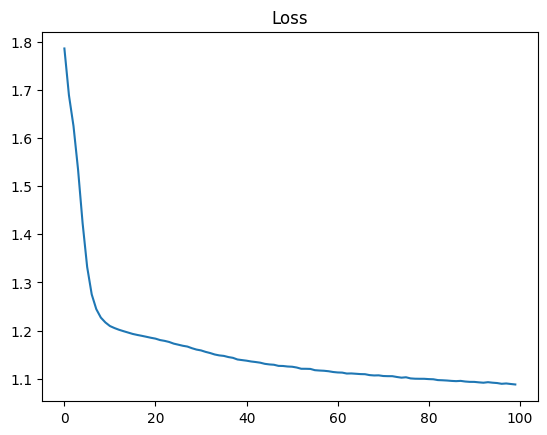

In [16]:
# Train
model.train()
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in tqdm(train_loader):
        for data in batch:
            input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
            target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)

            optimizer.zero_grad()
            output = model(input_tensor)  # (batch=1, seq_len) -> (batch=1, seq_len, VOCAB_SIZE)

            output_onehot = np.argmax(output.cpu().detach(), axis=2)  # (batch=1, seq_len)
            
            pred = output.view(-1, VOCAB_SIZE)  # (seq_len, VOCAB_SIZE)
            true = target_tensor.view(-1)  # (seq_len)
            # loss = F.cross_entropy(pred, true)  # Compare all (inefficient)
            
            eqi = data[:-1].index('=')
            lhs = torch.zeros_like(pred[:eqi])
            for i in range(eqi):
                lhs[i][true[i]] = 1
            rhs_pred = torch.cat((lhs, pred[eqi:]), dim=0)  # (seq_len, VOCAB_SIZE)
            loss = F.cross_entropy(rhs_pred, true)  # Compare RHS
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()/len(batch)
    losses.append(epoch_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]}")
    
    data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
    vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:{epoch+1}, Loss:{losses[-1]:.2f})')

plt.title('Loss'); plt.plot(losses)

In [17]:
test_dataset = AdditionDataset(num_samples=TEST_SAMPLE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

def evaluate_model(model, data):
    model.eval()  # 모델을 평가 모드로 설정
    
    pred_total = pred_correct = 0
    with torch.no_grad():
        for batch in test_loader:
            for data in batch:
                input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
                target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)
    
                output = model(input_tensor)

                output_onehot = np.argmax(output.cpu().detach(), axis=2)
                eqi = data[:-1].index('=')
                pred_total += len(target_tensor[0][eqi:])
                pred_correct += sum(1 for i, j in zip(target_tensor[0][eqi:], output_onehot[0][eqi:]) if i == j)
                print('sentence: ', data)
                print('target_char: ', [idx_to_char(i) for i in target_tensor[0][eqi:]])
                print('output_char: ', [idx_to_char(i) for i in output_onehot[0][eqi:]])

    return {'accuracy': pred_correct/pred_total}

accuracy = evaluate_model(model, test_dataset)['accuracy']

sentence:  79+45=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  56+47=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  81+50=131
target_char:  ['1', '3', '1']
output_char:  ['1', '3', '1']
sentence:  76+72=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  44+59=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  53+87=041
target_char:  ['0', '4', '1']
output_char:  ['0', '4', '1']
sentence:  16+12=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  87+80=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  68+50=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  67+42=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']


In [18]:
print("Accuracy: ", accuracy)

Accuracy:  1.0


In [19]:
# Write experimental results
filename=f'exp_res/{accuracy*100:.0f}-InRev{REVERSE_INPUT}-OutRev{REVERSE_OUTPUT}-{NUM1_RANGE}-{NUM2_RANGE}-Train{TRAINING_SAMPLE_SIZE}-Test{TEST_SAMPLE_SIZE}-Epoch{TRAINING_EPOCH}-{time.strftime("%Y%m%d-%H%M%S")}.txt'
with open(filename, 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Loss: {losses}\n')

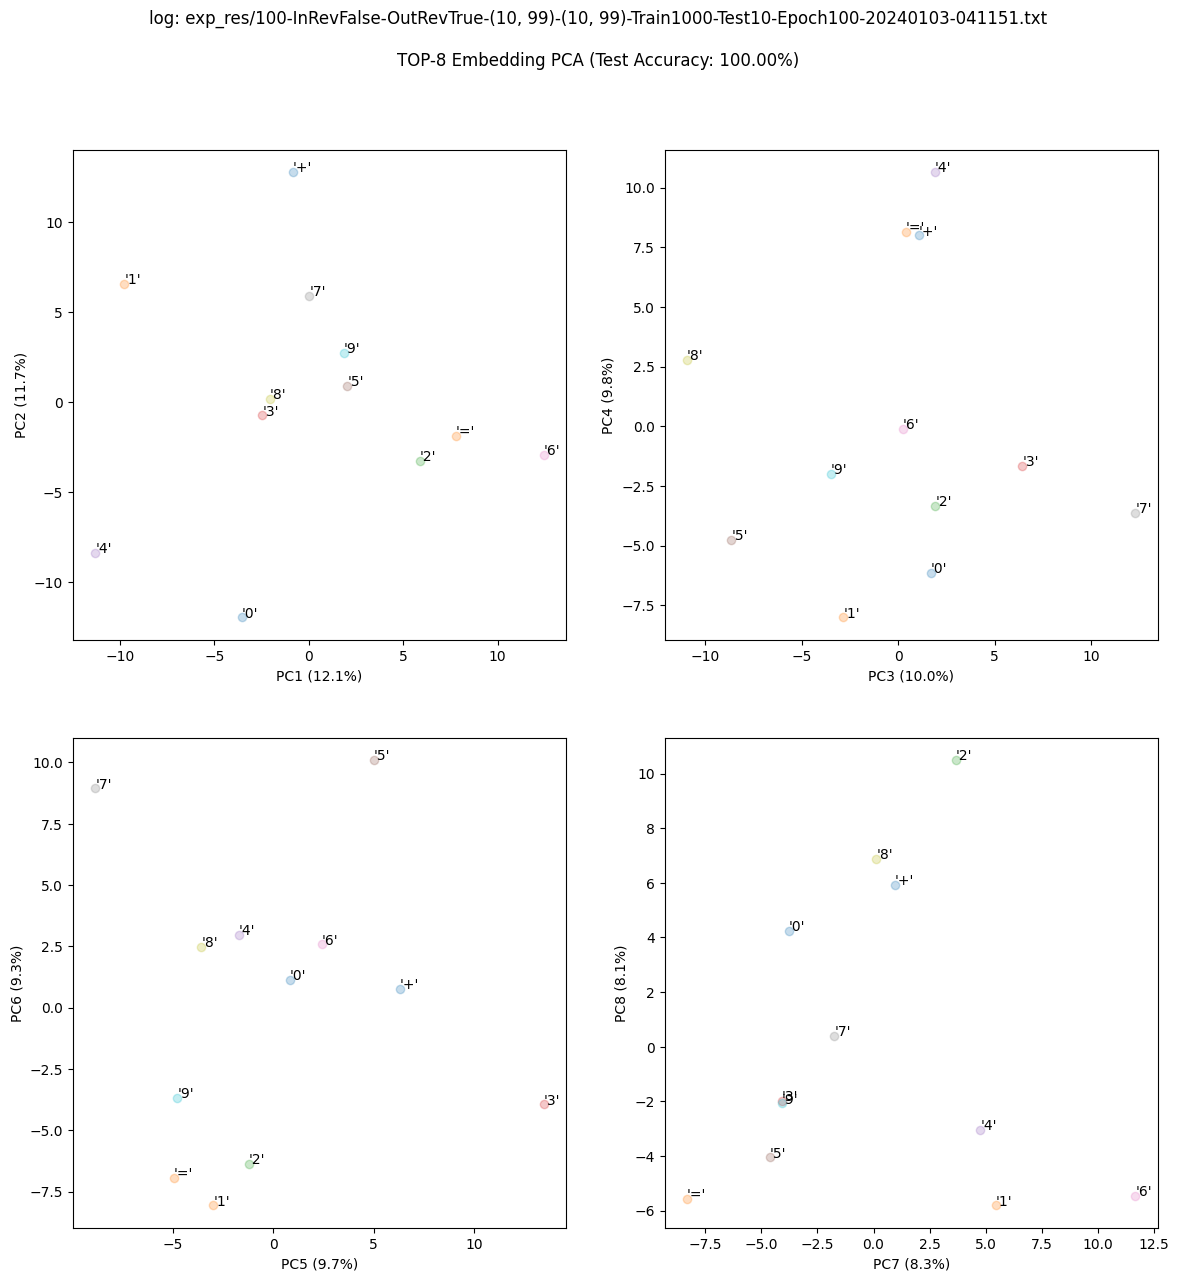

In [20]:
vis_pca(data, TOKENS, title=f'log: {filename}\n\n{PCA_TITLE_PREFIX} (Test Accuracy: {accuracy*100:.2f}%)', show=True)